## Create pipeline
In the section we will be creating a pipeline using this `python-sdk` to harness the power of `Instill VDP`!

Before we get into this, please make sure a local instance of `Instill VDP` and `Instill Model` is running,  and the config file had been populated with the correct `url` and `api_token`

Let's get started!

### Import packages

In [1]:
import base64
import requests

from google.protobuf.struct_pb2 import Struct
from instill.clients import get_client
from instill.resources.model import GithubModel
from instill.resources.schema import (
    instill,
    stabilityai,
    openai,
    instill_task_classification_input,
    openai_task_text_generation_input,
    stabilityai_task_text_to_image_input,
    start_task_start_metadata,
    end_task_end_metadata,
)
from instill.resources import (
    const,
    InstillModelConnector,
    OpenAIConnector,
    StabilityAIConnector,
    Pipeline,
    create_start_operator,
    create_end_operator,
    create_recipe,
)

### Get the client

Get the unified client that connect to all the available services offered by `Instill VDP` and `Instill Model`, including
- mgmt_service
- pipeline_service
- connector_service
- model_service

In [2]:
client = get_client()
# check the connection to all services
client.mgmt_service.is_serving()
# True
client.pipeline_service.is_serving()
# True
client.model_service.is_serving()
# True

user = client.mgmt_service.get_user()
# name: "users/admin"
# uid: "4767b74d-640a-4cdf-9c6d-7bb0e36098a0"
# id: "admin"
# ...
# ...

### Create a classification model

Now create and serve a classification model `mobilenetv2` in `Instill Model` for later use

In [3]:
model_name = "mobilenetv2"
model_repo = "instill-ai/model-mobilenetv2-dvc"
model_tag = "v1.0-cpu"
# create model
mobilenet = GithubModel(
  client=client,
  name=model_name,
  model_repo=model_repo,
  model_tag=model_tag,
)
# after creation, model is offline
# deploy model
mobilenet.deploy()

2

### Create connectors for various vendors
In order to form a pipeline, we first need to config a list of connector resources which will allow us to connect the pipeline to other third party services like OpenAI and Stability AI

In [4]:
# connector resource for Instill Model
instill_model_connector_config = instill.InstillModelConnector1(  #  currently the dataclass model name
    mode=const.INSTILL_MODEL_INTERNAL_MODE                        #  is auto-gen from the `title` field
)                                                                 #  in jsonschema, it will be updated
instill_connector = InstillModelConnector(
    client,
    name="instill",
    config=instill_model_connector_config,
)

# connector resource for OpenAI
openai_connector_config = openai.OpenAIConnectorResource(
    api_key="",  # remember to supply your own openai api_key here
)
openai_connector = OpenAIConnector(
    client,
    name="openai",
    config=openai_connector_config,
)

# connector resource for Stability AI
stability_connector_config = stabilityai.StabilityAIConnectorResource(
    api_key="",  # remember to supply your own openai api_key here
)
stability_connector = StabilityAIConnector(
    client,
    name="stabilityai",
    config=stability_connector_config,
)

### Create a pipeline

Now we are ready to construct a pipeline!

Let us create some components, for each components, we have schema hinted dataclass for user to better understand what parameters are supported or required for a particular component.

NOTE: `start operator` and `end operator` are the necessary components for a pipeline recipe.

In [5]:
# define your desired input, here we wish to input two base64 images
start_metadata = {}
start_metadata.update(
    {
        "image1": start_task_start_metadata.Model1(  #  currently the dataclass model name
            instillFormat="image/*",                 #  is auto-gen from the `title` field
            title="image1",                          #  in jsonschema, it will be updated
            type="string",
        )
    }
)
start_metadata.update(
    {
        "image2": start_task_start_metadata.Model1(
            instillFormat="image/*",
            title="image2",
            type="string",
        )
    }
)
start_operator_component = create_start_operator(start_metadata)

# create a instill model component from the connector resource
# need to specify the target model namepsace and id you want to connect to in the input config
instill_model_input_1 = instill_task_classification_input.Input(
    model_namespace="admin",
    model_id="mobilenetv2",
    image_base64="{ start.image1 }",
)
instill_model_component_mobilenet_1 = instill_connector.create_component(
    name="m1",
    inp=instill_model_input_1,
)

instill_model_input_2 = instill_task_classification_input.Input(
    model_namespace="admin",
    model_id="mobilenetv2",
    image_base64="{ start.image2 }",
)
instill_model_component_mobilenet_2 = instill_connector.create_component(
    name="m2",
    inp=instill_model_input_2,
)

# create an openai component and fill in the required config
openai_model_input = openai_task_text_generation_input.Input(
    prompt="write a upbeat story about friendship between {{ m1.output.category }} and {{ m2.output.category }}, in 64 words",
    model=openai_task_text_generation_input.Model.gpt_3_5_turbo.value,
    system_message="You are a skillful storywriter for childbook",
    response_format=openai_task_text_generation_input.ResponseFormat(
        type=openai_task_text_generation_input.Type.text.value
    ),
    max_tokens=64,
)
openai_component = openai_connector.create_component(
    name="gpt",
    inp=openai_model_input,
)

# create a stabilityai component and fill in the required config
stabilityai_model_input = stabilityai_task_text_to_image_input.Input(
    engine=stabilityai_task_text_to_image_input.Engine.stable_diffusion_xl_1024_v1_0.value,
    prompts="{gpt.output.texts}",
    width=896,
    height=1152,
    cfg_scale=7,
)
stability_ai_component = stability_connector.create_component(
    name="sd",
    inp=stabilityai_model_input,
)

# define the desired output
end_operator_inp = {}
end_operator_inp.update({"generated_image": "{{sd.output.images}}"})
end_operator_inp.update({"generated_story": "{{gpt.output.texts}}"})

end_operator_metadata = {}
end_operator_metadata.update(
    {"generated_image": end_task_end_metadata.Model1(title="result")}
)
end_operator_metadata.update(
    {"generated_story": end_task_end_metadata.Model1(title="result")}
)
end_operator_component = create_end_operator(end_operator_inp, end_operator_metadata)


# create recipe from the above components
recipe = create_recipe(
    [
        start_operator_component,
        instill_model_component_mobilenet_1,
        instill_model_component_mobilenet_2,
        openai_component,
        stability_ai_component,
        end_operator_component,
    ]
)

# finally we create the pipeline from the recipe and give it a name
story_pipeline = Pipeline(client=client, name="story-pipeline", recipe=recipe)

### Validate the pipeline

Before we trigger the pipeline, it is recommended to first validate the pipeline recipe first

In [6]:
# validate the pipeline recipe
story_pipeline.validate_pipeline()

True

### Trigger the pipeline

Now it is time to trigger this awesome pipeline!

In [10]:
# create a list of input images
i = Struct()
i.update(
    {
        "image1": base64.b64encode(
            requests.get(
                "https://artifacts.instill.tech/imgs/dog.jpg",
                timeout=5,
            ).content
        ).decode("ascii"),
        "image2": base64.b64encode(
            requests.get(
                "https://artifacts.instill.tech/imgs/polar-bear.jpg",
                timeout=5,
            ).content
        ).decode("ascii"),
    }
)

# trigger the pipeline
output = story_pipeline([i])[0][0]
story = output["generated_story"]
image = output["generated_image"]

In [11]:
# show the story
import pprint
pprint.pprint(story)

('Once upon a time, in a snowy land, lived a playful golden retriever named '
 'Sunny and a gentle ice bear named Frosty. They met while chasing a bouncing '
 "snowball and instantly became friends. Sunny's wagging tail warmed Frosty's "
 "heart, while Frosty's icy touch made Sunny giggle. Together,")


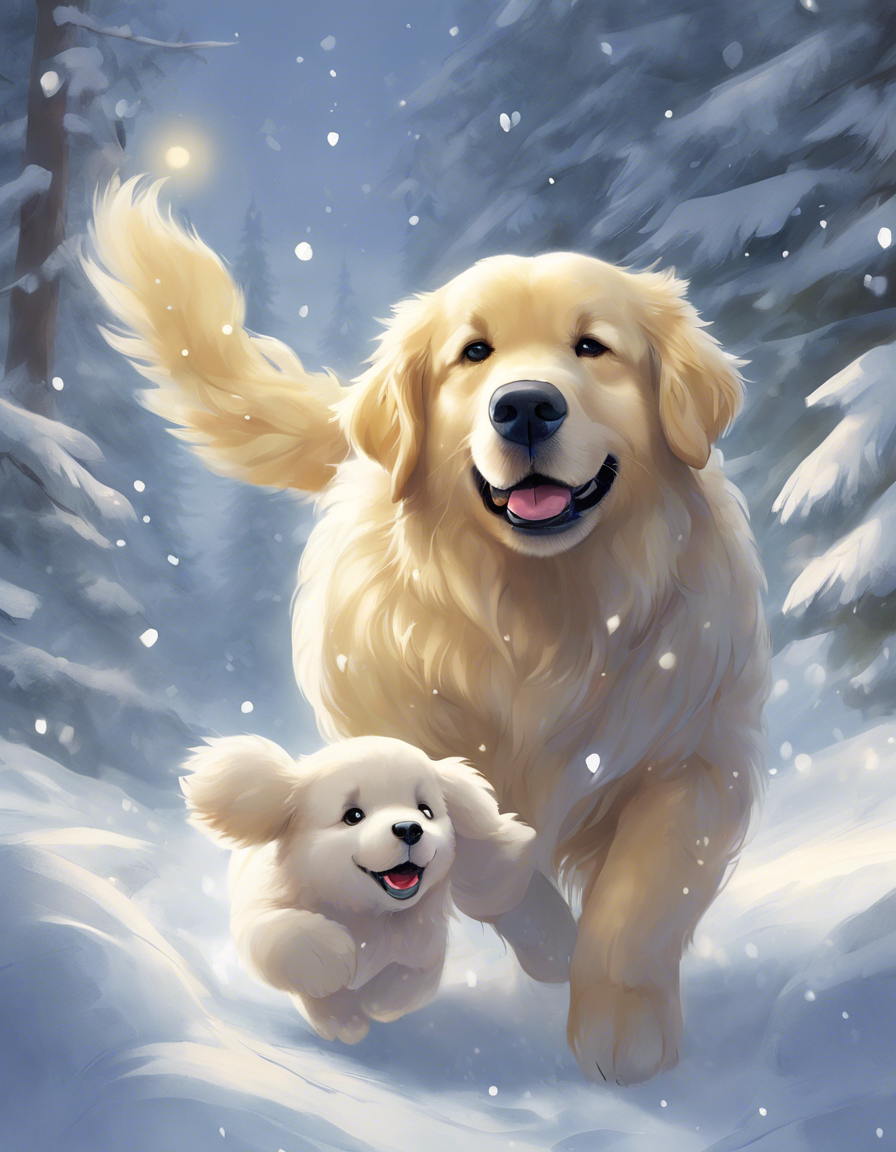

In [12]:
# show the image
from IPython.display import Image
Image(base64.b64decode(image.split(",")[1])) # remove URI scheme